Last updated: 16 Feb 2023

# 👋 PyCaret Multiclass Classification Tutorial

PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that exponentially speeds up the experiment cycle and makes you more productive.

Compared with the other open-source machine learning libraries, PyCaret is an alternate low-code library that can be used to replace hundreds of lines of code with a few lines only. This makes experiments exponentially fast and efficient. PyCaret is essentially a Python wrapper around several machine learning libraries and frameworks, such as scikit-learn, XGBoost, LightGBM, CatBoost, spaCy, Optuna, Hyperopt, Ray, and a few more.

The design and simplicity of PyCaret are inspired by the emerging role of citizen data scientists, a term first used by Gartner. Citizen Data Scientists are power users who can perform both simple and moderately sophisticated analytical tasks that would previously have required more technical expertise.


# 💻 Installation

PyCaret is tested and supported on the following 64-bit systems:
- Python 3.7 – 3.10
- Python 3.9 for Ubuntu only
- Ubuntu 16.04 or later
- Windows 7 or later

You can install PyCaret with Python's pip package manager:

`pip install pycaret`

PyCaret's default installation will not install all the extra dependencies automatically. For that you will have to install the full version:

`pip install pycaret[full]`

or depending on your use-case you may install one of the following variant:

- `pip install pycaret[analysis]`
- `pip install pycaret[models]`
- `pip install pycaret[tuner]`
- `pip install pycaret[mlops]`
- `pip install pycaret[parallel]`
- `pip install pycaret[test]`

In [1]:
# check installed version
import pycaret
pycaret.__version__

'3.3.2'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# 🚀 Quick start

PyCaret’s Classification Module is a supervised machine learning module that is used for classifying elements into groups. The goal is to predict the categorical class labels which are discrete and unordered. 

Some common use cases include predicting customer default (Yes or No), predicting customer churn (customer will leave or stay), the disease found (positive or negative). 

This module can be used for binary or multiclass problems. It provides several pre-processing features that prepare the data for modeling through the setup function. It has over 18 ready-to-use algorithms and several plots to analyze the performance of trained models.

A typical workflow in PyCaret consist of following 5 steps in this order:

## **Setup** ➡️ **Compare Models** ➡️ **Analyze Model** ➡️ **Prediction** ➡️ **Save Model**

In [3]:

# Cargar el dataset
file_path = 'dataset/safta.csv'
data = pd.read_csv(file_path, quotechar='"', delimiter=";")

columns_to_drop = ['EMPRESA', 'NUMERO_FACTURA', 'NUMERO_ASIENTO_BORRADOR', 'TIPO_FACTURA', 'DIARIO', 'IMPORTE_COBRADO_FRA', 'CUENTA_CONTABLE','NUM_EFECTOS_COBRADOS', 'NUM_EFECTOS_PARCIAL', 'NUM_EFECTOS_IMPAGADO', 'NUM_EFECTOS_FUERA_PLAZO', 'NUM_EFECTOS_PDTE_EN_PLAZO']
data.drop(columns=columns_to_drop, inplace=True)


In [4]:
conteo_categorias = data['CATEGORIA_FACTURA'].value_counts().reset_index()
conteo_categorias.columns = ['CATEGORIA_FACTURA', 'CONTEO']
print(conteo_categorias)

   CATEGORIA_FACTURA  CONTEO
0                 -1   89767
1                  2   20193
2                  1   10498
3                  0     997
4                 -2      49


In [5]:
df_filtrado = data

In [ ]:
# Filtrar las filas donde CATEGORIA no es -2
df_filtrado = data[data['CATEGORIA_FACTURA'] != -2]

In [6]:

# Split the data into training and testing sets
train_data = df_filtrado.sample(frac=0.8, random_state=0)
test_data = df_filtrado.drop(train_data.index)
# load the data into an autogluon tabular dataset
label = 'CATEGORIA_FACTURA'

## Setup
This function initializes the training environment and creates the transformation pipeline. Setup function must be called before executing any other function in PyCaret. It only has two required parameters i.e. `data` and `target`. All the other parameters are optional.

In [7]:
# import pycaret classification and init setup
from pycaret.classification import *
s = setup(df_filtrado, target = label, session_id = 123)

,Description,Value
0,Session id,123
1,Target,CATEGORIA_FACTURA
2,Target type,Multiclass
3,Target mapping,"-2: 0, -1: 1, 0: 2, 1: 3, 2: 4"
4,Original data shape,"(121504, 18)"
5,Transformed data shape,"(121504, 20)"
6,Transformed train set shape,"(85052, 20)"
7,Transformed test set shape,"(36452, 20)"
8,Numeric features,8
9,Categorical features,9


Once the setup has been successfully executed it shows the information grid containing experiment level information. 

- **Session id:**  A pseudo-random number distributed as a seed in all functions for later reproducibility. If no `session_id` is passed, a random number is automatically generated that is distributed to all functions.<br/>
<br/>
- **Target type:**  Binary, Multiclass, or Regression. The Target type is automatically detected. <br/>
<br/>
- **Label Encoding:**  When the Target variable is of type string (i.e. 'Yes' or 'No') instead of 1 or 0, it automatically encodes the label into 1 and 0 and displays the mapping (0 : No, 1 : Yes) for reference. In this tutorial, no label encoding is required since the target variable is of numeric type. <br/>
<br/>
- **Original data shape:**  Shape of the original data prior to any transformations. <br/>
<br/>
- **Transformed train set shape :**  Shape of transformed train set <br/>
<br/>
- **Transformed test set shape :**  Shape of transformed test set <br/>
<br/>
- **Numeric features :**  The number of features considered as numerical. <br/>
<br/>
- **Categorical features :**  The number of features considered as categorical. <br/>

PyCaret has two set of API's that you can work with. (1) Functional (as seen above) and (2) Object Oriented API.

With Object Oriented API instead of executing functions directly you will import a class and execute methods of class.

In [8]:
# import ClassificationExperiment and init the class
from pycaret.classification import ClassificationExperiment
exp = ClassificationExperiment()

In [9]:
# check the type of exp
type(exp)

pycaret.classification.oop.ClassificationExperiment

In [10]:
# init setup on exp
exp.setup(df_filtrado, target = label, session_id = 123 )

,Description,Value
0,Session id,123
1,Target,CATEGORIA_FACTURA
2,Target type,Multiclass
3,Target mapping,"-2: 0, -1: 1, 0: 2, 1: 3, 2: 4"
4,Original data shape,"(121504, 18)"
5,Transformed data shape,"(121504, 20)"
6,Transformed train set shape,"(85052, 20)"
7,Transformed test set shape,"(36452, 20)"
8,Numeric features,8
9,Categorical features,9


You can use any of the two method i.e. Functional or OOP and even switch back and forth between two set of API's. The choice of method will not impact the results and has been tested for consistency.

## Compare Models

This function trains and evaluates the performance of all the estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [11]:
# compare baseline models
best5 = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9568,0.9963,0.9568,0.9588,0.9576,0.8968,0.8969,0.4740
rf,Random Forest Classifier,0.9455,0.9953,0.9455,0.9491,0.9465,0.8692,0.8697,0.5630
catboost,CatBoost Classifier,0.9096,0.9928,0.9096,0.9164,0.9048,0.7765,0.7826,4.8490
lda,Linear Discriminant Analysis,0.9077,0.0000,0.9077,0.9068,0.9060,0.7745,0.7755,0.1220
knn,K Neighbors Classifier,0.9041,0.9563,0.9041,0.8969,0.8981,0.7554,0.7599,0.6280
xgboost,Extreme Gradient Boosting,0.8986,0.9872,0.8986,0.9055,0.8926,0.7485,0.7556,0.4060
ridge,Ridge Classifier,0.8935,0.0000,0.8935,0.8651,0.8591,0.7238,0.7368,0.1060
gbc,Gradient Boosting Classifier,0.8886,0.0000,0.8886,0.9058,0.8929,0.7348,0.7411,4.1120
lightgbm,Light Gradient Boosting Machine,0.8729,0.9371,0.8729,0.8875,0.8716,0.6908,0.6964,2.7660
dt,Decision Tree Classifier,0.8571,0.8734,0.8571,0.8694,0.8502,0.6556,0.6642,0.1290


In [13]:
metrics_df = pull()

In [16]:
metrics = metrics_df.iloc[0].to_dict()

In [17]:
print(metrics)

{'Model': 'Extra Trees Classifier', 'Accuracy': 0.9568, 'AUC': 0.9963, 'Recall': 0.9568, 'Prec.': 0.9588, 'F1': 0.9576, 'Kappa': 0.8968, 'MCC': 0.8969, 'TT (Sec)': 0.474}


In [42]:
best= best5.pop(0)

In [43]:
best

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     monotonic_cst=None, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)

In [44]:
best_model = tune_model(best, n_iter=50, optimize = 'F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7719,0.8593,0.7719,0.7641,0.7592,0.5479,0.5578
1,0.7689,0.8493,0.7689,0.7611,0.7585,0.5482,0.5535
2,0.7698,0.8512,0.7698,0.7626,0.7575,0.5445,0.5531
3,0.7737,0.8585,0.7737,0.7659,0.7623,0.5549,0.5624
4,0.7746,0.8569,0.7746,0.7663,0.7633,0.5571,0.5644
5,0.7750,0.8609,0.7750,0.7668,0.7620,0.5529,0.5641
6,0.7640,0.8436,0.7640,0.7553,0.7519,0.5334,0.5421
7,0.7725,0.8574,0.7725,0.7643,0.7621,0.5537,0.5602
8,0.7665,0.8526,0.7665,0.7570,0.7526,0.5374,0.5469


Fitting 10 folds for each of 50 candidates, totalling 500 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [40]:
blend_models(best5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7761,0.8767,0.7761,0.7725,0.7729,0.5770,0.5772
1,0.7700,0.8712,0.7700,0.7667,0.7669,0.5677,0.5678
2,0.7700,0.8704,0.7700,0.7704,0.7680,0.5703,0.5704
3,0.7842,0.8820,0.7842,0.7816,0.7815,0.5955,0.5956
4,0.7739,0.8765,0.7739,0.7701,0.7708,0.5775,0.5775
5,0.7723,0.8742,0.7723,0.7695,0.7698,0.5714,0.5715
6,0.7689,0.8711,0.7689,0.7645,0.7655,0.5658,0.5659
7,0.7795,0.8738,0.7795,0.7751,0.7761,0.5823,0.5827
8,0.7689,0.8733,0.7689,0.7645,0.7652,0.5639,0.5641


VotingClassifier(estimators=[('Extra Trees Classifier',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='sqrt',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   monotonic_cst=None,
                                                   n_estimators=100, n_jobs=-1...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))],
                 flatten_transform=True, n_jobs=-1, verbose=False,
                 voting='soft', weights=None)

In [41]:
stack_models(best5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7750,0.0000,0.7750,0.7730,0.7726,0.5789,0.5789
1,0.7662,0.0000,0.7662,0.7652,0.7647,0.5640,0.5641
2,0.7665,0.0000,0.7665,0.7687,0.7655,0.5662,0.5667
3,0.7806,0.0000,0.7806,0.7803,0.7790,0.5923,0.5924
4,0.7716,0.0000,0.7716,0.7693,0.7690,0.5758,0.5760
5,0.7705,0.0000,0.7705,0.7689,0.7688,0.5710,0.5711
6,0.7658,0.0000,0.7658,0.7634,0.7636,0.5633,0.5634
7,0.7815,0.0000,0.7815,0.7776,0.7787,0.5891,0.5892
8,0.7654,0.0000,0.7654,0.7620,0.7628,0.5596,0.5597


StackingClassifier(cv=5,
                   estimators=[('Extra Trees Classifier',
                                ExtraTreesClassifier(bootstrap=False,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=None,
                                                     max_features='sqrt',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     monotonic_cst=None,
                                                     n_estimators=100,
                                                     n_...
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                      dual=False,
                                                      fit_intercept=True,
                                                      intercept_scaling=1,
                                                      l1_ratio=None,
                                                      max_iter=1000,
                                                      multi_class='auto',
                                                      n_jobs=None, penalty='l2',
                                                      random_state=123,
                                                      solver='lbfgs',
                                                      tol=0.0001, verbose=0,
                                                      warm_start=False),
                   n_jobs=-1, passthrough=False, stack_method='auto',
                   verbose=0)

Notice that the output between functional and OOP API is consistent. Rest of the functions in this notebook will only be shown using functional API only. 

In [33]:
tuned_model = tune_model(best)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7408,0.8305,0.7408,0.7395,0.7393,0.5123,0.5132
1,0.7377,0.8189,0.7377,0.7437,0.7406,0.5152,0.5153
2,0.7379,0.8136,0.7379,0.7439,0.7408,0.5140,0.5141
3,0.7291,0.8256,0.7291,0.7454,0.7357,0.5118,0.5137
4,0.7408,0.8273,0.7408,0.7432,0.7417,0.5165,0.5168
5,0.7327,0.8233,0.7327,0.7422,0.7371,0.5108,0.5113
6,0.7228,0.8147,0.7228,0.7314,0.7269,0.4902,0.4903
7,0.7422,0.8330,0.7422,0.7500,0.7458,0.5279,0.5283
8,0.7386,0.8269,0.7386,0.7420,0.7400,0.5133,0.5137


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
ensenmble_model = ensemble_model(best, method='Bagging')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7860,0.8704,0.7860,0.7908,0.7867,0.6055,0.6064
1,0.7739,0.8635,0.7739,0.7823,0.7757,0.5872,0.5891
2,0.7790,0.8660,0.7790,0.7855,0.7801,0.5941,0.5955
3,0.7849,0.8783,0.7849,0.7952,0.7867,0.6095,0.6126
4,0.7845,0.8717,0.7845,0.7920,0.7861,0.6060,0.6078
5,0.7880,0.8697,0.7880,0.7929,0.7891,0.6097,0.6109
6,0.7757,0.8662,0.7757,0.7852,0.7776,0.5922,0.5949
7,0.7863,0.8681,0.7863,0.7907,0.7871,0.6069,0.6080
8,0.7800,0.8726,0.7800,0.7873,0.7812,0.5983,0.6003


In [35]:
ensemble_model2 = ensemble_model(best, method='Boosting')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7822,0.0000,0.7822,0.7892,0.7837,0.6007,0.6023
1,0.7680,0.0000,0.7680,0.7793,0.7706,0.5785,0.5813
2,0.7808,0.0000,0.7808,0.7870,0.7818,0.5975,0.5989
3,0.7896,0.0000,0.7896,0.7976,0.7910,0.6166,0.6189
4,0.7763,0.0000,0.7763,0.7853,0.7783,0.5927,0.5951
5,0.7775,0.0000,0.7775,0.7842,0.7791,0.5925,0.5941
6,0.7764,0.0000,0.7764,0.7859,0.7783,0.5937,0.5964
7,0.7827,0.0000,0.7827,0.7875,0.7837,0.6013,0.6026
8,0.7818,0.0000,0.7818,0.7882,0.7826,0.6011,0.6029


## Analyze Model

You can use the `plot_model` function to analyzes the performance of a trained model on the test set. It may require re-training the model in certain cases.

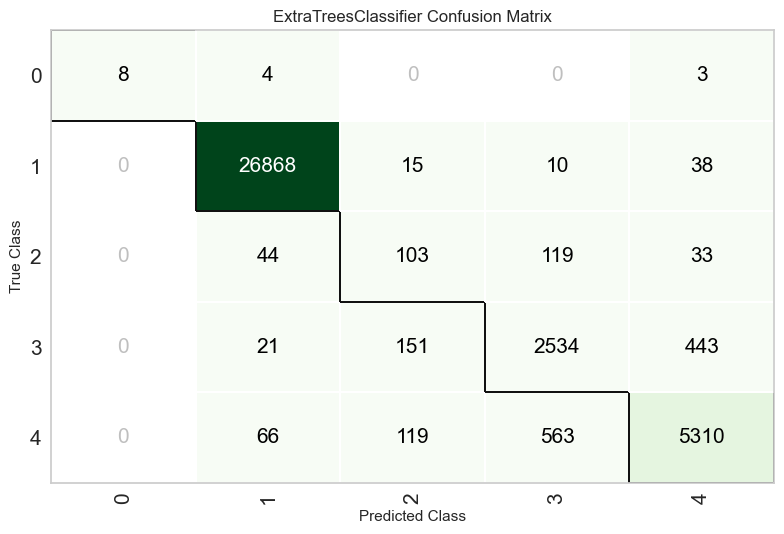

In [13]:
# plot confusion matrix
plot_model(best, plot = 'confusion_matrix')

In [14]:
# plot AUC
plot_model(best, plot = 'accuracy')

ValueError: Plot Not Available. Please see docstring for list of available Plots.

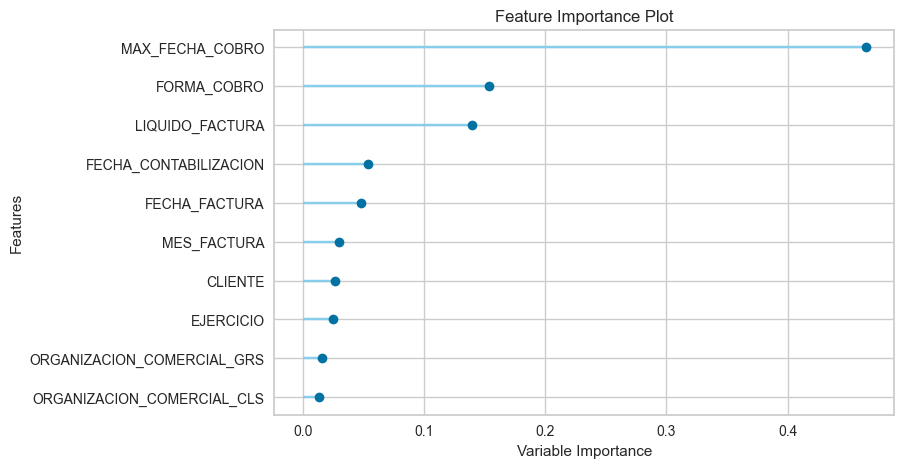

In [15]:
# plot feature importance
plot_model(best, plot = 'feature')

In [ ]:
# check docstring to see available plots 
help(plot_model)

An alternate to `plot_model` function is `evaluate_model`. It can only be used in Notebook since it uses ipywidget.

In [16]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Prediction
The `predict_model` function returns `prediction_label` and `prediction_score` (probability of the predicted class) as new columns in dataframe. When data is `None` (default), it uses the test set (created during the setup function) for scoring.

In [ ]:
# predict on test set
holdout_pred = predict_model(best)

In [ ]:
# show predictions df
holdout_pred.head()

The same function works for predicting the labels on unseen dataset. Let's create a copy of original data and drop the `Class variable`. We can then use the new data frame without labels for scoring.

In [ ]:
# copy data and drop Class variable

new_data = data.copy()
new_data.drop('CATEGORIA_FACTURA', axis=1, inplace=True)
new_data.head()

In [ ]:
# predict model on new_data
predictions = predict_model(best, data = new_data)
predictions.head()

## Save Model

Finally, you can save the entire pipeline on disk for later use, using pycaret's `save_model` function.

In [ ]:
# save pipeline
save_model(best, 'my_first_pipeline')

In [ ]:
# load pipeline
loaded_best_pipeline = load_model('my_first_pipeline')
loaded_best_pipeline

# 👇 Detailed function-by-function overview

## ✅ Setup
This function initializes the experiment in PyCaret and creates the transformation pipeline based on all the parameters passed in the function. Setup function must be called before executing any other function. It takes two required parameters: `data` and `target`. All the other parameters are optional and are used for configuring data preprocessing pipeline.

In [ ]:
s = setup(data, target = 'CATEGORIA_FACTURA', session_id = 123)

To access all the variables created by the setup function such as transformed dataset, random_state, etc. you can use `get_config` method.

In [ ]:
# check all available config
get_config()

In [ ]:
# lets access X_train_transformed
get_config('X_train_transformed')

In [ ]:
# another example: let's access seed
print("The current seed is: {}".format(get_config('seed')))

# now lets change it using set_config
set_config('seed', 786)
print("The new seed is: {}".format(get_config('seed')))

All the preprocessing configurations and experiment settings/parameters are passed into the `setup` function. To see all available parameters, check the docstring:

In [ ]:
help(setup)

In [ ]:
# init setup with normalize = True

s = setup(data, target = 'CATEGORIA_FACTURA', session_id = 123,
          normalize = True, normalize_method = 'minmax')

In [ ]:
# lets check the X_train_transformed to see effect of params passed
get_config('X_train_transformed')['sepal_length'].hist()

Notice that all the values are between 0 and 1 - that is because we passed `normalize=True` in the `setup` function. If you don't remember how it compares to actual data, no problem - we can also access non-transformed values using `get_config` and then compare. See below and notice the range of values on x-axis and compare it with histogram above.

In [ ]:
get_config('X_train')['sepal_length'].hist()

## ✅ Compare Models
This function trains and evaluates the performance of all estimators available in the model library using cross-validation. The output of this function is a scoring grid with average cross-validated scores. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
best = compare_models()

`compare_models` by default uses all the estimators in model library (all except models with `Turbo=False`) . To see all available models you can use the function `models()`

In [ ]:
# check available models
models()

You can use the `include` and `exclude` parameter in the `compare_models` to train only select model or exclude specific models from training by passing the model id's in `exclude` parameter.

In [ ]:
compare_tree_models = compare_models(include = ['dt', 'rf', 'et', 'gbc', 'xgboost', 'lightgbm', 'catboost'])

In [ ]:
compare_tree_models

The function above has return trained model object as an output. The scoring grid is only displayed and not returned. If you need access to the scoring grid you can use `pull` function to access the dataframe.

In [ ]:
compare_tree_models_results = pull()
compare_tree_models_results

By default `compare_models` return the single best performing model based on the metric defined in the `sort` parameter. Let's change our code to return 3 top models based on `Recall`.

In [ ]:
best_recall_models_top3 = compare_models(sort = 'Recall', n_select = 3)

In [ ]:
# list of top 3 models by Recall
best_recall_models_top3

Some other parameters that you might find very useful in `compare_models` are:

- fold
- cross_validation
- budget_time
- errors
- probability_threshold
- parallel

You can check the docstring of the function for more info.

In [ ]:
help(compare_models)

## ✅ Experiment Logging
PyCaret integrates with many different type of experiment loggers (default = 'mlflow'). To turn on experiment tracking in PyCaret you can set `log_experiment` and `experiment_name` parameter. It will automatically track all the metrics, hyperparameters, and artifacts based on the defined logger.

In [ ]:
# from pycaret.classification import *
# s = setup(data, target = 'Class variable', log_experiment='mlflow', experiment_name='iris_experiment')

In [ ]:
# compare models
# best = compare_models()

In [ ]:
# start mlflow server on localhost:5000
# !mlflow ui

By default PyCaret uses `MLFlow` logger that can be changed using `log_experiment` parameter. Following loggers are available:
    
    - mlflow
    - wandb
    - comet_ml
    - dagshub
    
Other logging related parameters that you may find useful are:

- experiment_custom_tags
- log_plots
- log_data
- log_profile

For more information check out the docstring of the `setup` function.

In [ ]:
# help(setup)

## ✅ Create Model
This function trains and evaluates the performance of a given estimator using cross-validation. The output of this function is a scoring grid with CV scores by fold. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function. All the available models can be accessed using the models function.

In [ ]:
# check all the available models
models()

In [ ]:
# train logistic regression with default fold=10
lr = create_model('lr')

The function above has return trained model object as an output. The scoring grid is only displayed and not returned. If you need access to the scoring grid you can use `pull` function to access the dataframe.

In [ ]:
lr_results = pull()
print(type(lr_results))
lr_results

In [ ]:
# train logistic regression with fold=3
lr = create_model('lr', fold=3)

In [ ]:
# train logistic regression with specific model parameters
create_model('lr', C = 0.5, l1_ratio = 0.15)

In [ ]:
# train lr and return train score as well alongwith CV
create_model('lr', return_train_score=True)

Some other parameters that you might find very useful in `create_model` are:

- cross_validation
- engine
- fit_kwargs
- groups

You can check the docstring of the function for more info.

In [ ]:
# help(create_model)

## ✅ Tune Model

This function tunes the hyperparameters of the model. The output of this function is a scoring grid with cross-validated scores by fold. The best model is selected based on the metric defined in optimize parameter. Metrics evaluated during cross-validation can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
# train a dt model with default params
dt = create_model('dt')

In [ ]:
# tune hyperparameters of dt
tuned_dt = tune_model(dt)

Metric to optimize can be defined in `optimize` parameter (default = 'Accuracy'). Also, a custom tuned grid can be passed with `custom_grid` parameter. 

In [ ]:
dt

In [ ]:
# define tuning grid
dt_grid = {'max_depth' : [None, 2, 4, 6, 8, 10, 12]}

# tune model with custom grid and metric = F1
tuned_dt = tune_model(dt, custom_grid = dt_grid, optimize = 'F1')

In [ ]:
# to access the tuner object you can set return_tuner = True
tuned_dt, tuner = tune_model(dt, return_tuner=True)

In [ ]:
# model object
tuned_dt

In [ ]:
# tuner object
tuner

The default search algorithm is `RandomizedSearchCV` from `sklearn`. This can be changed by using `search_library` and `search_algorithm` parameter.

In [ ]:
# tune dt using optuna
tuned_dt = tune_model(dt, search_library = 'optuna')

For more details on all available `search_library` and `search_algorithm` please check the docstring. Some other parameters that you might find very useful in `tune_model` are:

- choose_better
- n_iter
- early_stopping
- groups

You can check the docstring of the function for more info.

In [ ]:
# help(tune_model)

## ✅ Ensemble Model

This function ensembles a given estimator. The output of this function is a scoring grid with CV scores by fold. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
# ensemble with bagging
ensemble_model(dt, method = 'Bagging')

In [ ]:
# ensemble with boosting
ensemble_model(dt, method = 'Boosting')

Some other parameters that you might find very useful in `ensemble_model` are:

- choose_better
- n_estimators
- groups
- fit_kwargs
- probability_threshold
- return_train_score

You can check the docstring of the function for more info.

In [ ]:
# help(ensemble_model)

## ✅ Blend Models

This function trains a Soft Voting / Majority Rule classifier for select models passed in the estimator_list parameter. The output of this function is a scoring grid with CV scores by fold. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
# top 3 models based on recall
best_recall_models_top3

In [ ]:
# blend top 3 models
blend_models(best_recall_models_top3)

Some other parameters that you might find very useful in `blend_models` are:

- choose_better
- method
- weights
- fit_kwargs
- probability_threshold
- return_train_score

You can check the docstring of the function for more info.

In [ ]:
# help(blend_models)

## ✅ Stack Models

This function trains a meta-model over select estimators passed in the estimator_list parameter. The output of this function is a scoring grid with CV scores by fold. Metrics evaluated during CV can be accessed using the `get_metrics` function. Custom metrics can be added or removed using `add_metric` and `remove_metric` function.

In [ ]:
# stack models
stack_models(best_recall_models_top3)

Some other parameters that you might find very useful in `stack_models` are:

- choose_better
- meta_model
- method
- restack
- probability_threshold
- return_train_score

You can check the docstring of the function for more info.

In [ ]:
# help(stack_models)

In [ ]:
get_metrics()

## ✅ Plot Model

This function analyzes the performance of a trained model on the hold-out set. It may require re-training the model in certain cases.

In [ ]:
# plot class report
plot_model(best, plot = 'class_report')

In [ ]:
# to control the scale of plot
plot_model(best, plot = 'class_report', scale = 2)

In [ ]:
# to save the plot
plot_model(best, plot = 'class_report', save=True)

Some other parameters that you might find very useful in `plot_model` are:

- fit_kwargs
- plot_kwargs
- groups
- display_format

You can check the docstring of the function for more info.

In [ ]:
# help(plot_model)

## ✅ Interpret Model

This function analyzes the predictions generated from a trained model. Most plots in this function are implemented based on the SHAP (Shapley Additive exPlanations). For more info on this, please see https://shap.readthedocs.io/en/latest/

In [ ]:
# train lightgbm model
lightgbm = create_model('lightgbm')

In [ ]:
!pip install shap

In [ ]:
# interpret summary model
interpret_model(best, plot = 'summary')

In [ ]:
# reason plot for test set observation 1
interpret_model(lightgbm, plot = 'reason', observation = 1)

Some other parameters that you might find very useful in `interpret_model` are:

- plot
- feature
- use_train_data
- X_new_sample
- y_new_sample
- save

You can check the docstring of the function for more info.

In [ ]:
# help(interpret_model)

## ✅ Get Leaderboard

This function returns the leaderboard of all models trained in the current setup.

In [ ]:
# get leaderboard
lb = get_leaderboard()
lb

In [ ]:
# select the best model based on F1
lb.sort_values(by='F1', ascending=False)['Model'].iloc[0]

Some other parameters that you might find very useful in `get_leaderboard` are:

- finalize_models
- fit_kwargs
- model_only
- groups

You can check the docstring of the function for more info.

In [ ]:
# help(get_leaderboard)

## ✅ AutoML
This function returns the best model out of all trained models in the current setup based on the optimize parameter. Metrics evaluated can be accessed using the `get_metrics` function.

In [ ]:
automl()

## ✅ Dashboard
The dashboard function generates the interactive dashboard for a trained model. The dashboard is implemented using `ExplainerDashboard`. For more information check out [Explainer Dashboard.](explainerdashboard.readthedocs.io)

In [ ]:
# dashboard function
dashboard(dt, display_format ='inline')

## ✅Create App
This function creates a basic gradio app for inference.

In [ ]:
# create gradio app
create_app(best)

## ✅ Create API
This function takes an input model and creates a POST API for inference.

In [ ]:
# create api
create_api(best, api_name = 'my_first_api')

In [ ]:
# !python my_first_api.py

In [ ]:
# check out the .py file created with this magic command
# %load my_first_api.py

## ✅ Create Docker
This function creates a `Dockerfile` and `requirements.txt` for productionalizing API end-point.

In [ ]:
create_docker('my_first_api')

In [ ]:
# check out the DockerFile file created with this magic command
# %load DockerFile

In [ ]:
# check out the requirements file created with this magic command
# %load requirements.txt

## ✅ Finalize Model
This function trains a given model on the entire dataset including the hold-out set.

In [ ]:
final_best = finalize_model(best)

In [ ]:
final_best

## ✅ Convert Model
This function transpiles the trained machine learning model's decision function in different programming languages such as Python, C, Java, Go, C#, etc. It is very useful if you want to deploy models into environments where you can't install your normal Python stack to support model inference.

In [ ]:
# transpiles learned function to java
print(convert_model(dt, language = 'java'))

## ✅ Deploy Model
This function deploys the entire ML pipeline on the cloud.

**AWS:**  When deploying model on AWS S3, environment variables must be configured using the command-line interface. To configure AWS environment variables, type `aws configure` in terminal. The following information is required which can be generated using the Identity and Access Management (IAM) portal of your amazon console account:

- AWS Access Key ID
- AWS Secret Key Access
- Default Region Name (can be seen under Global settings on your AWS console)
- Default output format (must be left blank)

**GCP:** To deploy a model on Google Cloud Platform ('gcp'), the project must be created using the command-line or GCP console. Once the project is created, you must create a service account and download the service account key as a JSON file to set environment variables in your local environment. Learn more about it: https://cloud.google.com/docs/authentication/production

**Azure:** To deploy a model on Microsoft Azure ('azure'), environment variables for the connection string must be set in your local environment. Go to settings of storage account on Azure portal to access the connection string required.
AZURE_STORAGE_CONNECTION_STRING (required as environment variable)
Learn more about it: https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-python?toc=%2Fpython%2Fazure%2FTOC.json

In [ ]:
# deploy model on aws s3
# deploy_model(best, model_name = 'my_first_platform_on_aws',
#             platform = 'aws', authentication = {'bucket' : 'pycaret-test'})

In [ ]:
# load model from aws s3
# loaded_from_aws = load_model(model_name = 'my_first_platform_on_aws', platform = 'aws',
#                              authentication = {'bucket' : 'pycaret-test'})

# loaded_from_aws

## ✅ Save / Load Model
This function saves the transformation pipeline and a trained model object into the current working directory as a pickle file for later use.

In [ ]:
# save model
save_model(best, 'my_first_model')

In [ ]:
# load model
loaded_from_disk = load_model('my_first_model')
loaded_from_disk

## ✅ Save / Load Experiment
This function saves all the experiment variables on disk, allowing to later resume without rerunning the setup function.

In [ ]:
# save experiment
save_experiment('my_experiment')

In [ ]:
# load experiment from disk
exp_from_disk = load_experiment('my_experiment', data=data)